# Token Projection AUC Analysis

This notebook analyzes the Area Under the Curve (AUC) for token projection across different variance thresholds, providing a comprehensive measure of how the residual stream's information is distributed between token prediction and persistent memory/reasoning.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from token_projection_auc import compute_projection_auc, compare_task_types

/Users/kyle/Documents/ws/latent-space-reasoning-interp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Comparing Different Task Types

Let's run the predefined comparison between factual recall and reasoning tasks.

Loading model: gpt2-small
Loaded pretrained model gpt2-small into HookedTransformer
Model loaded with 768 dimensions and 12 layers
Getting unembedding matrix...
Unembedding matrix shape: (768, 50257)
Computing SVD (this might take a moment)...
Token variance AUC: 0.7013

Analyzing prompt: 'Factual (capitals)'

Analyzing prompt: 'Factual (elements)'

Analyzing prompt: 'Reasoning (math)'

Analyzing prompt: 'Reasoning (logic)'


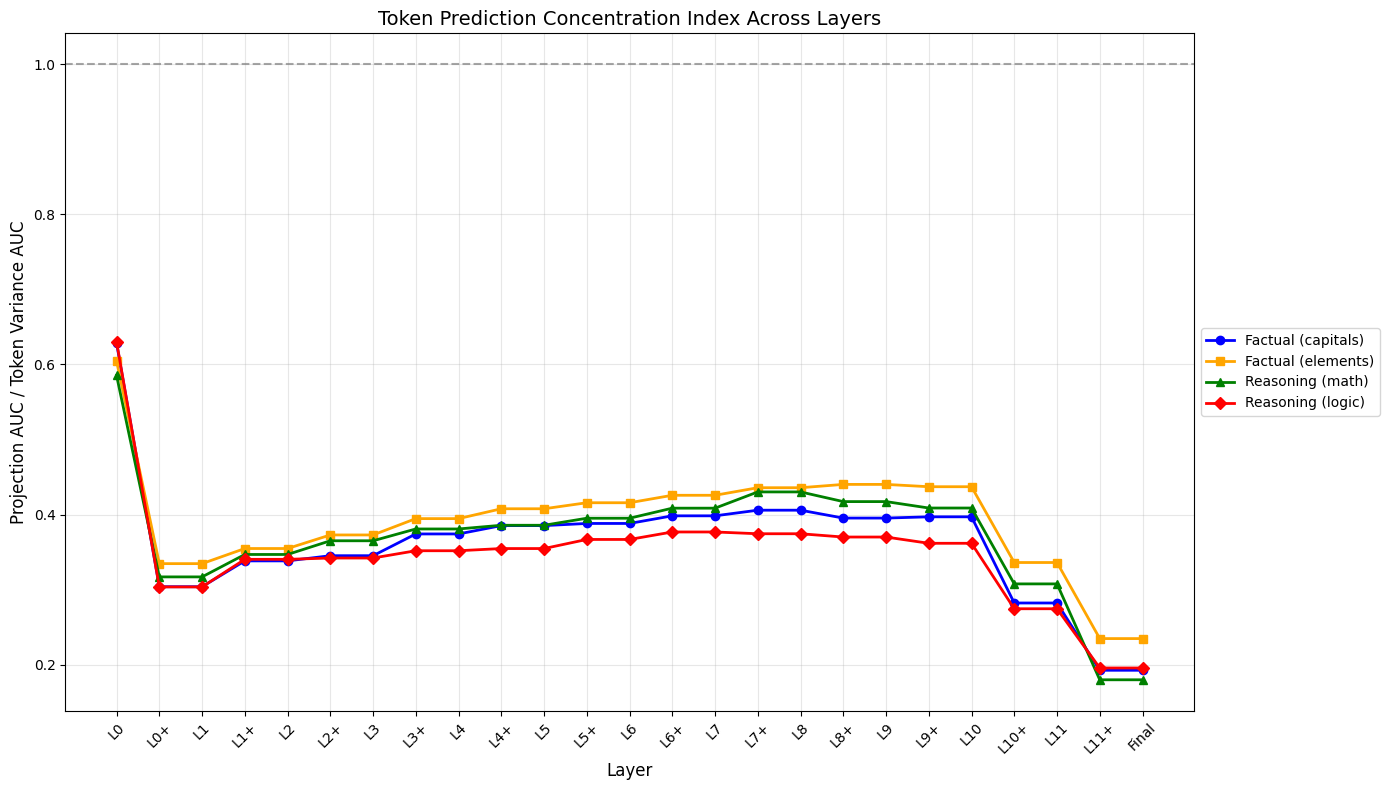

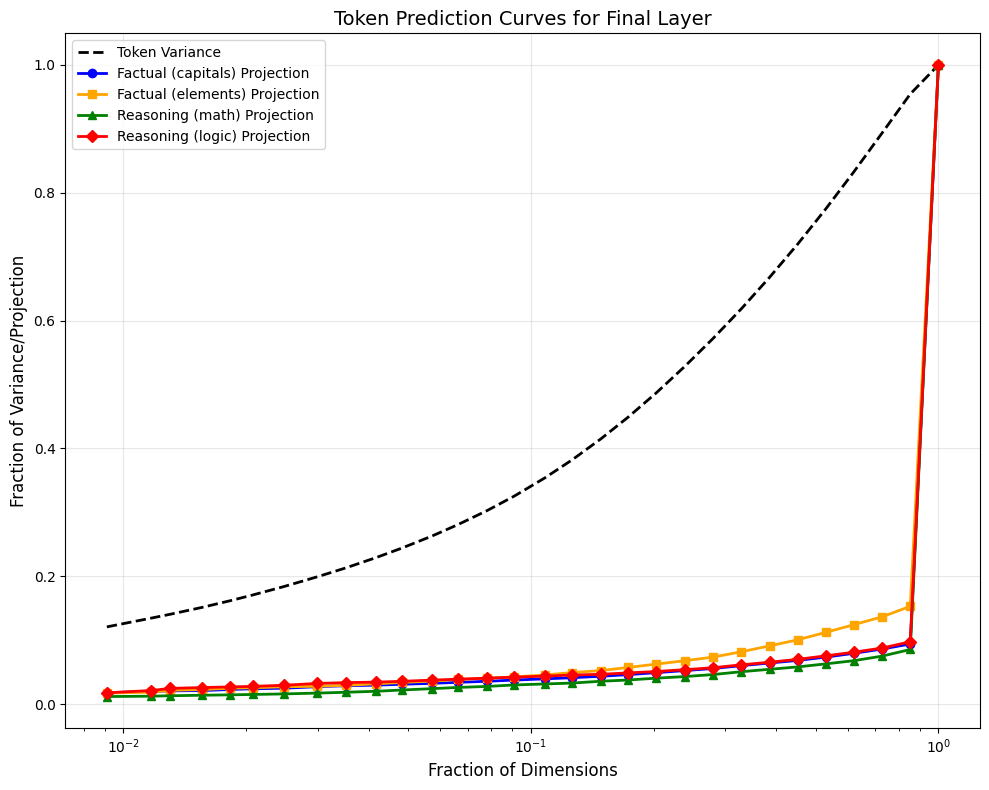


=== Final Layer Concentration Indices ===
Factual (capitals): 0.1928
Factual (elements): 0.2350
Reasoning (math): 0.1801
Reasoning (logic): 0.1958


In [2]:
# Run the predefined task comparison
results = compare_task_types()

## Custom Prompt Analysis

Let's analyze some custom prompts of our choosing.

Loading model: gpt2-small
Loaded pretrained model gpt2-small into HookedTransformer
Model loaded with 768 dimensions and 12 layers
Getting unembedding matrix...
Unembedding matrix shape: (768, 50257)
Computing SVD (this might take a moment)...
Token variance AUC: 0.7013

Analyzing prompt: 'Simple Factual'

Analyzing prompt: 'Complex Factual'

Analyzing prompt: 'Simple Reasoning'

Analyzing prompt: 'Complex Reasoning'


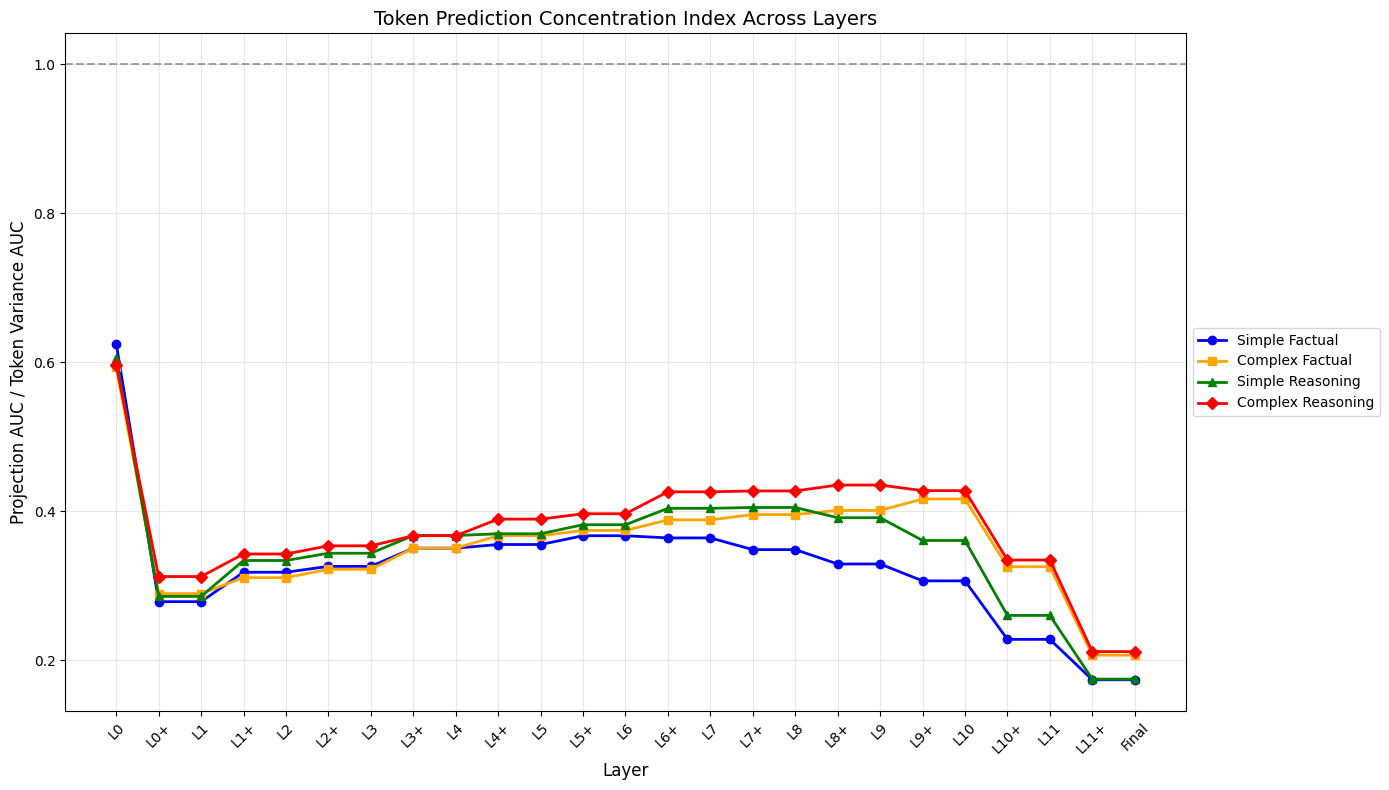

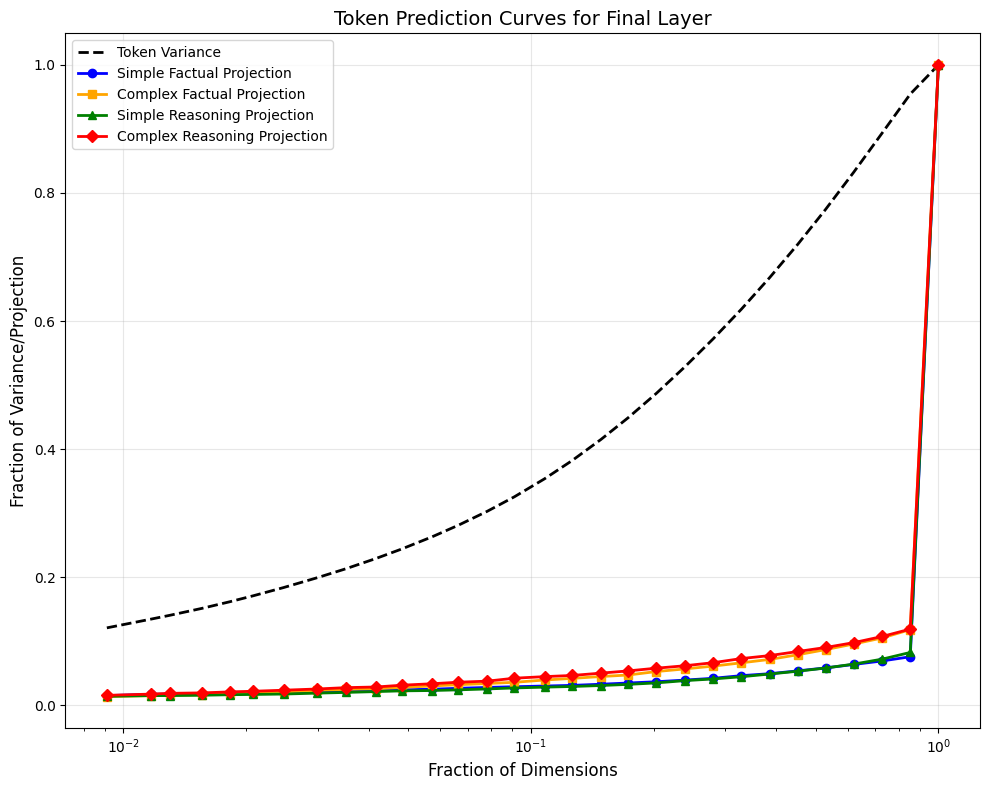


=== Final Layer Concentration Indices ===
Simple Factual: 0.1741
Complex Factual: 0.2071
Simple Reasoning: 0.1749
Complex Reasoning: 0.2119


In [6]:
# Define custom prompts
custom_prompts = {
    "Simple Factual": "The color of the sky is",
    "Complex Factual": "The currency of Japan is the yen, the currency of the UK is the pound, and the currency of Brazil is the",
    "Simple Reasoning": "If today is Monday, then tomorrow is",
    "Complex Reasoning": "To calculate the area of a circle, you need to multiply pi by the radius squared. If a circle has radius 3, its area is"
}

# Run analysis on custom prompts
custom_results = compute_projection_auc(custom_prompts, model_name="gpt2-small")

## Understanding the Concentration Index

The "concentration index" (AUC ratio) captures how concentrated the layer's information is relative to the token prediction function:

- **Index > 1.0**: Layer's information is more concentrated than the token prediction function itself. This suggests the layer is very focused on a few directions that matter for token prediction, potentially optimizing for immediate output.

- **Index = 1.0**: Layer's information has the same concentration as the token prediction function. This is a neutral state where the layer's information distribution matches the unembedding matrix.

- **Index < 1.0**: Layer's information is less concentrated than the token prediction function. This suggests the layer is using more directions than strictly necessary for token prediction, potentially maintaining information for future reasoning steps.

Let's examine how this index varies across different layers and between factual and reasoning tasks:

Loading model: gpt2-small
Loaded pretrained model gpt2-small into HookedTransformer
Model loaded with 768 dimensions and 12 layers
Getting unembedding matrix...
Unembedding matrix shape: (768, 50257)
Computing SVD (this might take a moment)...
Token variance AUC: 0.7013

Analyzing prompt: 'Storing Info'

Analyzing prompt: 'Immediate Use'

Analyzing prompt: 'Deep Reasoning'


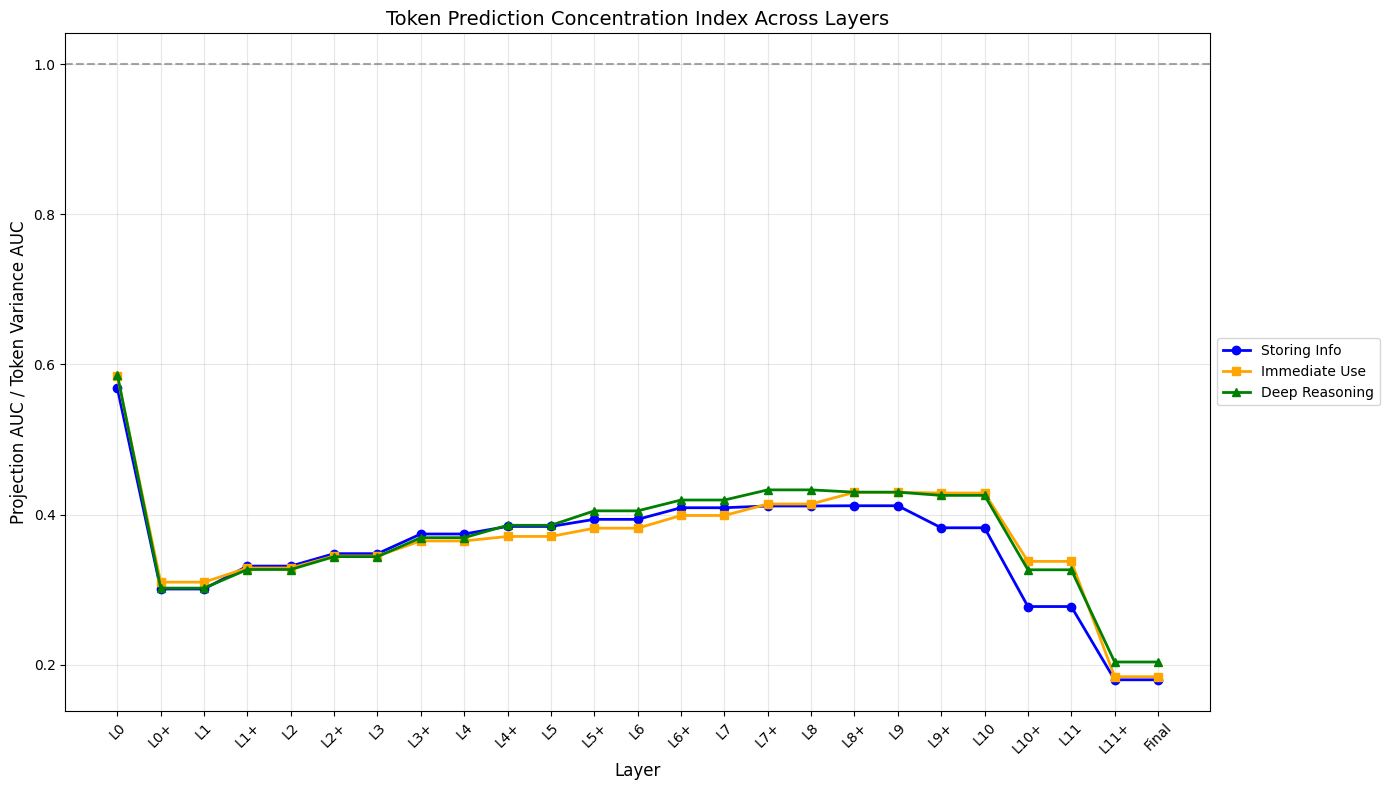

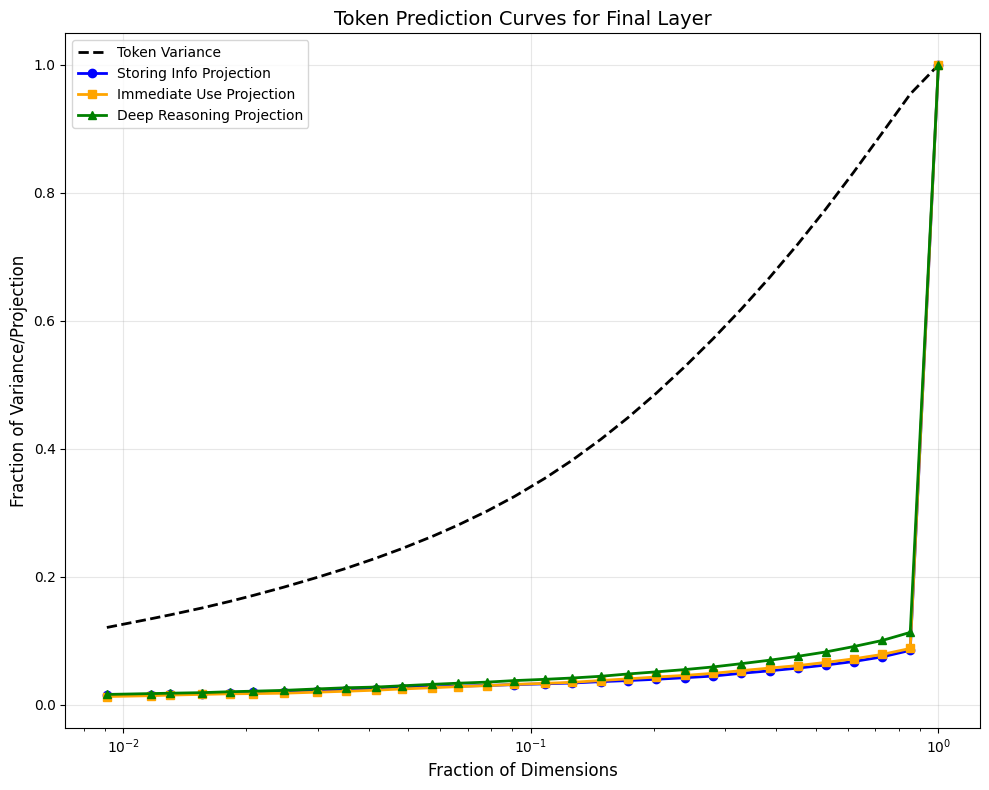


=== Final Layer Concentration Indices ===
Storing Info: 0.1799
Immediate Use: 0.1840
Deep Reasoning: 0.2036


In [7]:
# Define more complex reasoning vs. memory tasks
memory_prompts = {
    "Storing Info": "Remember these numbers for later reference: 7, 15, 23, 42, 56. We'll use them in calculations at the end. First, let's discuss how to",
    "Immediate Use": "Let's calculate the sum of these numbers: 7, 15, 23, 42, 56. Adding them together, we get 7 + 15 + 23 + 42 + 56 =",
    "Deep Reasoning": "If a shirt costs $15 and is on sale for 20% off, first we calculate 20% of $15, which is $3. Then we subtract this from the original price to get"
}

# Run analysis
memory_results = compute_projection_auc(memory_prompts, model_name="gpt2-small")

## Interpreting the Results

The AUC analysis provides several key insights:

1. **Layer Progression**: How the concentration index changes from early to later layers indicates the progression from "thinking" to "outputting" modes.

2. **Task Differences**: Differences in the index between factual recall and reasoning tasks show how task complexity affects the information distribution in the residual stream.

3. **Memory vs. Expression**: The "Storing Info" vs. "Immediate Use" prompts highlight how the model handles information differently based on whether it needs to be expressed now or remembered for later.

These patterns provide strong evidence for your hypothesis about the dual role of the residual stream in both token prediction and persistent memory/reasoning.

## Curve Analysis for Specific Layers

Let's extract and compare the full projection curves for specific layers of interest:

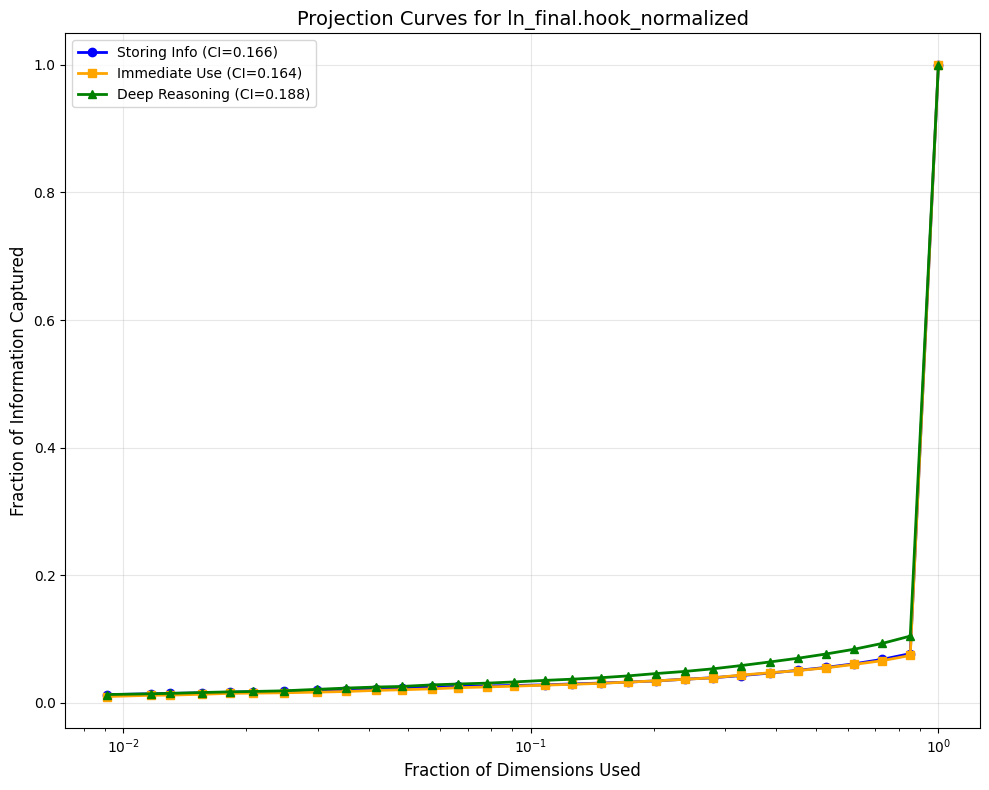

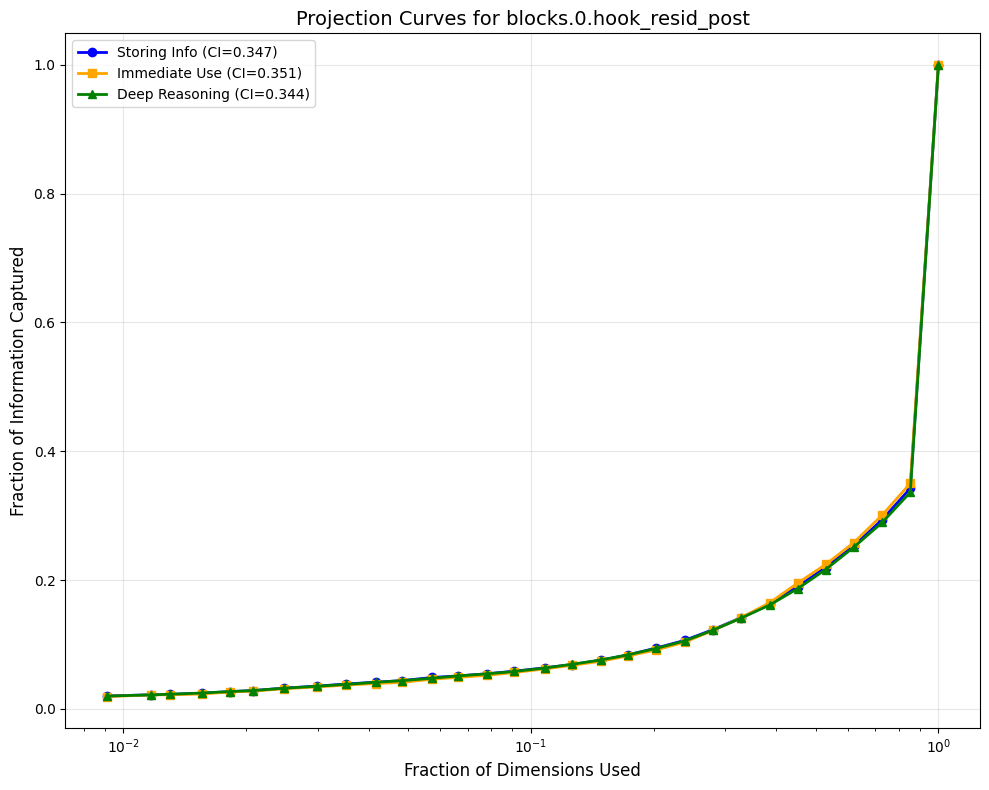

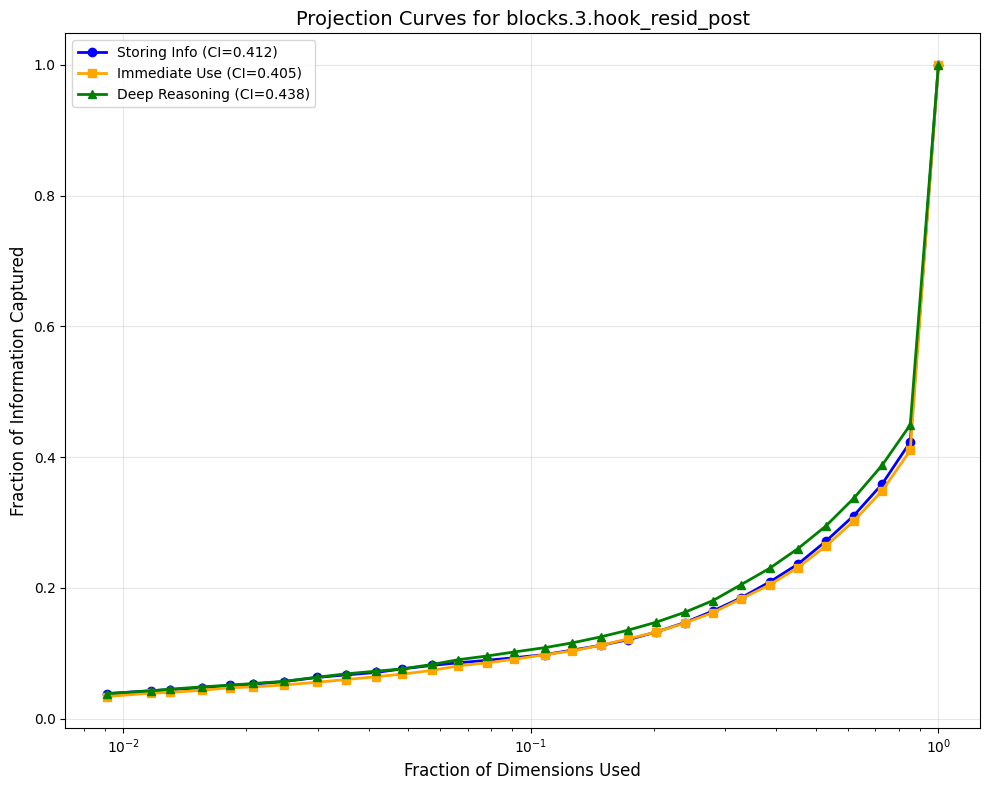

In [5]:
def plot_layer_curves(results, layer_name="ln_final.hook_normalized"):
    """Plot projection curves for a specific layer across different prompts."""
    plt.figure(figsize=(10, 8))
    
    # Get token variance curve from first prompt (same for all)
    first_prompt = list(results.keys())[0]
    token_variance_curve = None
    for layer_data in results[first_prompt].values():
        if "token_variance_curve" in layer_data:
            token_variance_curve = layer_data["token_variance_curve"]
            break
    
    if token_variance_curve:
        var_x = [p[0] for p in token_variance_curve]
        var_y = [p[1] for p in token_variance_curve]
        plt.plot(var_x, var_y, 'k--', label='Token Variance', linewidth=2)
    
    # Plot each prompt's projection curve for the specified layer
    markers = ['o', 's', '^', 'D', 'x', '*', 'p', 'h']
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
    
    for i, (prompt_name, prompt_results) in enumerate(results.items()):
        if layer_name in prompt_results:
            projection_curve = prompt_results[layer_name]["projection_curve"]
            auc_ratio = prompt_results[layer_name]["auc_ratio"]
            
            proj_x = [p[0] for p in projection_curve]
            proj_y = [p[1] for p in projection_curve]
            
            marker = markers[i % len(markers)]
            color = colors[i % len(colors)]
            plt.plot(proj_x, proj_y, marker=marker, color=color, 
                     label=f"{prompt_name} (CI={auc_ratio:.3f})", linewidth=2)
    
    # Set up the plot
    plt.xlabel('Fraction of Dimensions Used', fontsize=12)
    plt.ylabel('Fraction of Information Captured', fontsize=12)
    plt.title(f'Projection Curves for {layer_name}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xscale('log')  # Log scale to better see behavior at small dimensions
    plt.tight_layout()
    
    plt.show()

# Compare curves for the final layer
plot_layer_curves(memory_results, "ln_final.hook_normalized")

# Compare curves for an early layer (layer 0 post-attention)
plot_layer_curves(memory_results, "blocks.0.hook_resid_post")

# Compare curves for a middle layer (layer 3 post-attention)
plot_layer_curves(memory_results, "blocks.3.hook_resid_post")